# RNN architecture implementation from Scratch using pytorch

After reading this notebook you will get the in-depth insight about Recurrent Neural Network (RNN):
1. **what problems of the feed forward Neural Network have RNN solved?**
2. **Understand the RNN architecture and its working mechanism**
3. **Mathematical understanding of forward pass and backprogration through time**
4. **How to implement it in pytorch ?**
5. **Limitation of RNN**

## 📢 Prerequisites
Please note that before moving forward, it is better to have the fundamentation knowledge of
1. python
2. pytorch
3. feed-forward neural network

## Feed-forward Neural Network (FFNN) and its limitation
If you are familiar with this architecture, then I assume you already know about the feed-forward neural network. It is a simple neural network architecture where data flows in one direction --input to output layer. Please, not that here data flow in one direction does not mean there is no backpropagation, it actually means there is no loops within each or intermediate layers. Don't worry about the "loops", we will come to that later.

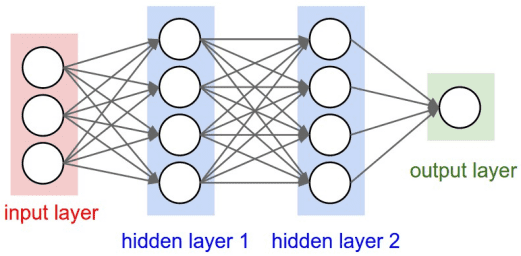

### ⚠️ Limitation of feed-forward neural network over sequential data

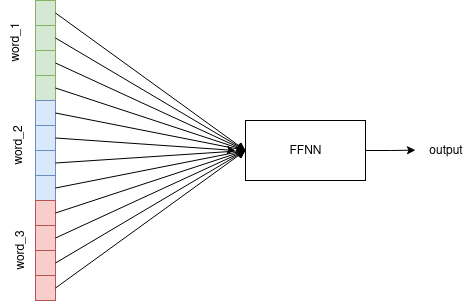

Natural langauges or sentences are in a sequential form where order of words in the sentence matters.
For instance, ***"man killed lion"*** and ***"lion killed man"*** has two different meaning. 
1. **Since we pass the entire sentence (input features) at once in FFNN ,there is no information about the orders of input features**
    - FFNN treats input features independently
2. **Fixed input size**
   - sequential data varies in length, for a task of sentence classifier or audio classifier, the input sequence may varies.
   - FFNN expect a fixed length input vector, thus need to add paddings or tuncate the sequence
3. **High dimensionality for long sequence**
   - To handle large sequence, the input feature vector becomes large.As a result model becomes large and training becomes in-efficient.


So to solve the limitation of FFNN, we need to build someting that should be capable of taking varying length input size as well as preserve the order of the sequencial data. In a simple word, we need to build a model that reads one word at a time from a sentence instead of reading entire sentence at once which FFNN was doing.

## RNN architecture
We need to build something like the one shown below.

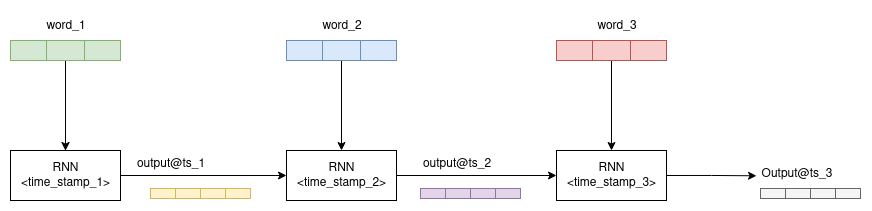

Here, unlike feed-forward network we are passing one word at a time to the same model in a loop and the output getting from T-1 step (timestamp) is passed to the model along with the next input. **Output@ts_i** is behaving like a memory which is basically a n-dim vector containing contextual information of all the information about previous words. With this we have solved the ordering issue, now at T step model know which words has occurred previously and which one is occurring now.


Now let's build this RNN block, which basically takes previous step output and the current step input.
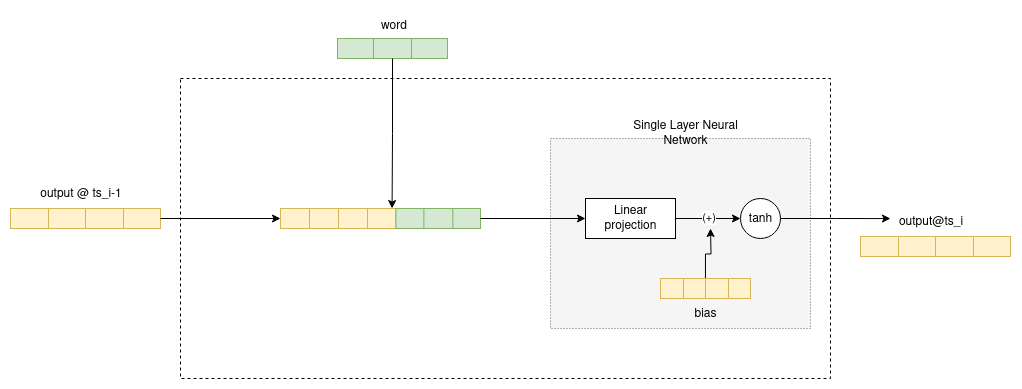

- we first concatinate the output vector with the word vector, let's say we have a word vector of dimension (1X3) and output vector of dimension (1X4), so after concatination it will become (1X4+3) = (1X7).
- Now the dimension got increased we cannot directly pass it to the next step as it is also there will be no learning if we do so. One of the best way to add learnability here as well as reduce the concatinated vector size to the output vector size is to use neural network.
- Here the purpose of the single layer neural network is to perform linear projection to takes the concatinate vector from the higher dimension to the output vector dimension as well as add bias term.
- For the stable training and adding non-linearity, we add an activation function.
- Out of all the option "tanh" is suitable because authors found it helping in stable trainign could be because of 
     - it maps the value to the range (-1, 1), that captures Polarity (positive/negative influence)
          - +1 is a positive influence
          - -1 is a negative influence
     - Sigmoid’s gradient max is 0.25, while tanh’s gradient max is 1, meaning less prune to vanishing gradient descent.

congralulations, you have successfully architecture a RNN model. 🎉🥳

# Mathematically
Now let's view the RNN architecture mathematically.

$$
O_t = O_{t-1} W_o + X_t W_i + b
$$
$$
O_t = \tanh(O_t)
$$

Or it can also be written as:

$$
O_t = concat(O_{t-1}, X_t) * W + b 
$$
$$
O_t = \tanh(O_t)
$$

where,

- **O_{t-1} :** (batch_size, 1, n) dim output vector of t-1 step
- **X_t :** (batch_size, 1, m) dim current input vector of t step
- **b**: (1, n ) dim bias vector
- **W**: weight matrix of shape (n+m, n)
- **O_t**: (batch_size, 1, n) dim output vector of t step

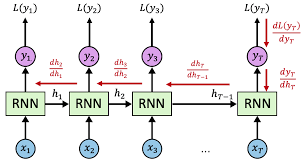

## RNN cell

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
x = torch.tensor([
            [[1., 2, 3], [11, 12, 13]],
            [[4, 5, 6], [14, 15, 16]]
        ])

x[:, 1, :]

tensor([[11., 12., 13.],
        [14., 15., 16.]])

In [43]:
x

tensor([[[ 1.,  2.,  3.],
         [11., 12., 13.]],

        [[ 4.,  5.,  6.],
         [14., 15., 16.]]])

In [44]:
w = torch.randn(3, 4)
w

tensor([[ 0.4926,  0.0369,  1.2713, -0.8272],
        [-0.5283, -0.7532,  0.6611, -0.8676],
        [-0.7577, -0.3673,  1.1971, -1.4055]])

In [45]:
torch.matmul(x[:, 1, :], w)

tensor([[-10.7716, -13.4079,  37.4805, -37.7811],
        [-13.1519, -16.6588,  46.8692, -47.0818]])

In [76]:
class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicRNNCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # weight input -> hidden layer
        self.W_ih = nn.Parameter(torch.randn(hidden_size, input_size)) #hidden_size X input_size
        self.b_ih = nn.Parameter(torch.zeros(hidden_size)) # hidden_size 

        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size)) # hidden_size X hidden_size 
        self.b_hh = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_prev): # X -> (num_batch X input_size), h_prev -> hidden_size
        hx = torch.matmul(x, self.W_ih.T) + self.b_ih # dim -> 
        hh = torch.matmul(h_prev, self.W_hh.T) + self.b_hh
        opt_add = hx + hh
        h_new = torch.tanh(opt_add)
        return h_new

**1. Weights (W_ih, W_hh, etc.) are already nn.Parameters.**
- When you later call .to(device) or .cuda() on the whole model, all parameters automatically move to that device.
- So you don’t need to do .to(device) for weights manually.

**2. The hidden state is created at runtime (not registered as a parameter).**
- Unlike model weights, h_prev is not part of the model definition—it’s initialized fresh in each forward pass.
- That means you must explicitly place it on the same device as the input.

In [77]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn_cell = BasicRNNCell(input_size, hidden_size)
        self.fcc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq): #input x -> (batch_size, seq_length, input_length)
        outputs = [] #all intermediate outputs

        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        # initialize hidden state for the first time step
        h_prev = torch.zeros(self.batch_size, self.hidden_size).to(input_seq.device)

        for t in range(0, self.seq_length):
            x = input_seq[:, t, :]
            h_prev = self.rnn_cell(x, h_prev)
            outputs.append(h_prev)

        
        final_hidden_state = outputs[-1]
        fcc_output = self.fcc(final_hidden_state)
        return outputs, fcc_output

In [78]:
x = torch.randn(2, 2, 3)
x

tensor([[[ 0.5513,  1.9902,  0.8487],
         [ 0.4283,  0.2501,  0.7806]],

        [[-0.5592, -1.1399, -0.4532],
         [ 1.2435,  0.9734,  0.2442]]])

In [79]:
rnn = SimpleRNN(3, 5, 4)

In [80]:
rnn(x)

([tensor([[ 0.9139, -0.5025,  0.5457, -0.6236,  0.9411],
          [-0.6836,  0.0783, -0.3515,  0.1294, -0.7462]],
         grad_fn=<TanhBackward0>)],
 tensor([[ 0.0878, -0.2284, -0.4436, -0.1627],
         [ 0.0813, -0.0474, -0.0203, -0.4455]], grad_fn=<AddmmBackward0>))

## Deep RNN

In [81]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(2, 2) for _ in range(3)])

model = MyModel()
print(list(model.parameters()))  

[Parameter containing:
tensor([[ 0.5036,  0.6165],
        [-0.0032, -0.5465]], requires_grad=True), Parameter containing:
tensor([-0.6149, -0.1452], requires_grad=True), Parameter containing:
tensor([[ 0.2896, -0.5080],
        [-0.6100,  0.3226]], requires_grad=True), Parameter containing:
tensor([-0.1623,  0.6844], requires_grad=True), Parameter containing:
tensor([[-0.0452, -0.5710],
        [-0.6854,  0.0813]], requires_grad=True), Parameter containing:
tensor([0.4535, 0.3425], requires_grad=True)]


In [82]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Linear(2, 2)

model = MyModel()
print(list(model.parameters()))  

[Parameter containing:
tensor([[-0.1235,  0.0653],
        [ 0.1050,  0.4650]], requires_grad=True), Parameter containing:
tensor([0.6589, 0.5476], requires_grad=True)]


In [108]:
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(DeepRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn_cells = nn.ModuleList()
        for layer_idx in range(self.num_layers):
            layer_input_size = input_size if layer_idx == 0 else hidden_size
            rnn_cell = BasicRNNCell(layer_input_size, hidden_size)
            self.rnn_cells.append(rnn_cell)
            
        self.fcc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq): #input x -> (batch_size, seq_length, input_length)
        outputs = [] #all intermediate outputs

        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        # initialize hidden state for the first time step
        h_prevs = [torch.zeros(self.batch_size, self.hidden_size).to(input_seq.device)
                   for _ in range(self.num_layers)]
        print(h_prevs)
        for t in range(0, self.seq_length):
            x = input_seq[:, t, :]

            for layer_idx in range(self.num_layers):
                print(layer_idx)
                h_prevs[layer_idx] = self.rnn_cells[layer_idx](x, h_prevs[layer_idx])
                x = h_prevs[layer_idx]
            
            outputs.append(h_prevs[-1])

        
        final_hidden_state = outputs[-1]
        fcc_output = self.fcc(final_hidden_state)
        return outputs, fcc_output

In [109]:
x = torch.randn(2, 2, 3)
x

tensor([[[-2.0890,  0.5391, -1.0589],
         [-0.4403, -1.7302,  0.0778]],

        [[ 1.3574, -2.0764,  0.2127],
         [ 1.1984,  1.3025, -0.8878]]])

In [110]:
rnn = DeepRNN(3, 5, 4, 2)

In [111]:
rnn(x)

[tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])]
0
1


([tensor([[-0.9680,  0.9876, -0.3500, -0.9641,  0.9920],
          [ 0.8934, -0.9930,  0.7778,  0.9414, -0.9956]],
         grad_fn=<TanhBackward0>)],
 tensor([[ 0.0343, -0.3500,  0.8475, -0.3142],
         [ 0.3871, -0.1134, -0.7403, -0.0412]], grad_fn=<AddmmBackward0>))

In [112]:
print(list(rnn.parameters()))  

[Parameter containing:
tensor([[ 0.3739, -0.9181,  0.4878],
        [ 1.6532,  0.8488,  0.8004],
        [-0.8955,  1.7390,  1.1154],
        [-2.6128,  1.4924, -1.0881],
        [-0.7256,  0.2005,  0.9398]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.3830,  0.8413,  2.1346, -0.7052,  1.3731],
        [-0.9727,  1.0224, -0.3425, -1.3543,  0.7105],
        [-0.1063,  1.2921, -1.1673, -0.5311,  0.1015],
        [ 1.6865,  0.2294,  0.0211,  1.2628, -1.4024],
        [ 1.2976,  0.7801,  0.9583, -1.0618, -0.5619]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[ 0.6145,  0.7800,  0.9749, -2.0867,  0.8714],
        [-1.7824,  0.2679, -0.5643,  1.3492,  0.5230],
        [ 0.8719, -0.7574,  0.5556, -0.0933, -1.2890],
        [ 0.8794,  0.4911,  0.7410, -1.4119,  0.0842],
        [-1.5952, -0.4816, -0.9505,  0.6069,  1.8657]], requires_